In [ ]:
!pip install qiskit==1.2.4
!pip install matplotlib
!pip install qiskit-aer==0.15.1
!pip install seaborn==0.13.2
!pip install qiskit-ibm-runtime==0.32.0
!pip install pylatexenc
!pip install qiskit-ibm-provider==0.11.0  # Latest available version
!pip uninstall qiskit-ibm-runtime qiskit-ibmq-provider -y
!pip install qiskit-ibm-runtime==0.32.0
!pip install qiskit matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created w

In [ ]:
# # Import necessary libraries
# from qiskit import *
# from qiskit.quantum_info import Statevector, Operator
# from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector
# from qiskit_aer import Aer
# import numpy as np
# from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
# import matplotlib.pyplot as plt  # Required to display plots
# from qiskit import transpile
# from qiskit import QuantumCircuit
# from qiskit.visualization import plot_state_hinton, plot_histogram
# import math
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.primitives import Sampler as LocalSampler
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler


In [ ]:

def create_phase_oracle(theta):
    """Create the phase oracle U|1⟩ = e^(2πiθ)|1⟩"""
    return np.array([[1, 0],
                    [0, np.exp(2j * np.pi * theta)]])

def create_qpe_circuit(n_counting_qubits, theta):
    # Create quantum registers
    c = QuantumRegister(n_counting_qubits, 'counting')
    t = QuantumRegister(1, 'target')
    cl = ClassicalRegister(n_counting_qubits, 'cl')

    # Create circuit
    qc = QuantumCircuit(c, t, cl)

    # Initialize target state to |1⟩
    qc.x(t[0])

    # Hadamard on counting qubits
    for i in range(n_counting_qubits):
        qc.h(c[i])

    # Create and apply controlled phase rotations
    U = UnitaryGate(create_phase_oracle(theta), label='U')
    for i in range(n_counting_qubits):
        for _ in range(2**i):
            qc.append(U.control(1), [c[n_counting_qubits-1-i], t[0]])

    # Apply inverse QFT
    qc.append(QFT(n_counting_qubits, do_swaps=False).inverse(), c)

    # Measure
    qc.measure(c, cl)

    return qc

In [ ]:
def execute_qpe(n_counting_qubits, theta, shots=1024):
    # Create the circuit
    qc = create_qpe_circuit(n_counting_qubits, theta)

    # Get the simulator backend
    backend = Aer.get_backend('aer_simulator')

    # Transpile the circuit for the backend
    transpiled_qc = transpile(qc, backend=backend, optimization_level=3)

    # Print circuit information
    print(f"\nNumber of qubits: {n_counting_qubits}")
    print(f"Original circuit depth: {qc.depth()}")
    print(f"Transpiled circuit depth: {transpiled_qc.depth()}")
    print(f"Original number of operations: {sum(qc.count_ops().values())}")
    print(f"Transpiled number of operations: {sum(transpiled_qc.count_ops().values())}")

    # Execute the circuit
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Process results
    measured_phases = []
    for bitstring, count in counts.items():
        phase = int(bitstring, 2) / (2**n_counting_qubits)
        measured_phases.extend([phase] * count)

    return np.mean(measured_phases)

In [ ]:

from qiskit.circuit.library import UnitaryGate, QFT

# Execute QPE for different numbers of qubits
theta = 3/5
n_qubits_range = range(3, 15)
results = []

print("Executing QPE with proper transpilation:")
print("---------------------------------------")

for n_qubits in n_qubits_range:
    measured_theta = execute_qpe(n_qubits, theta)
    precision = abs(measured_theta - theta)
    results.append({
        'n_qubits': n_qubits,
        'measured_theta': measured_theta,
        'precision': precision
    })
    print(f"Measured theta: {measured_theta}")
    print(f"Precision: {precision}")
    print("---------------------------------------")

Executing QPE with proper transpilation:
---------------------------------------

Number of qubits: 3
Original circuit depth: 10
Transpiled circuit depth: 12
Original number of operations: 15
Transpiled number of operations: 17
Measured theta: 0.6151123046875
Precision: 0.015112304687500022
---------------------------------------

Number of qubits: 4
Original circuit depth: 18
Transpiled circuit depth: 15
Original number of operations: 25
Transpiled number of operations: 23
Measured theta: 0.59375
Precision: 0.006249999999999978
---------------------------------------

Number of qubits: 5
Original circuit depth: 34
Transpiled circuit depth: 18
Original number of operations: 43
Transpiled number of operations: 30
Measured theta: 0.595672607421875
Precision: 0.004327392578124978
---------------------------------------

Number of qubits: 6
Original circuit depth: 66
Transpiled circuit depth: 21
Original number of operations: 77
Transpiled number of operations: 38
Measured theta: 0.5946044

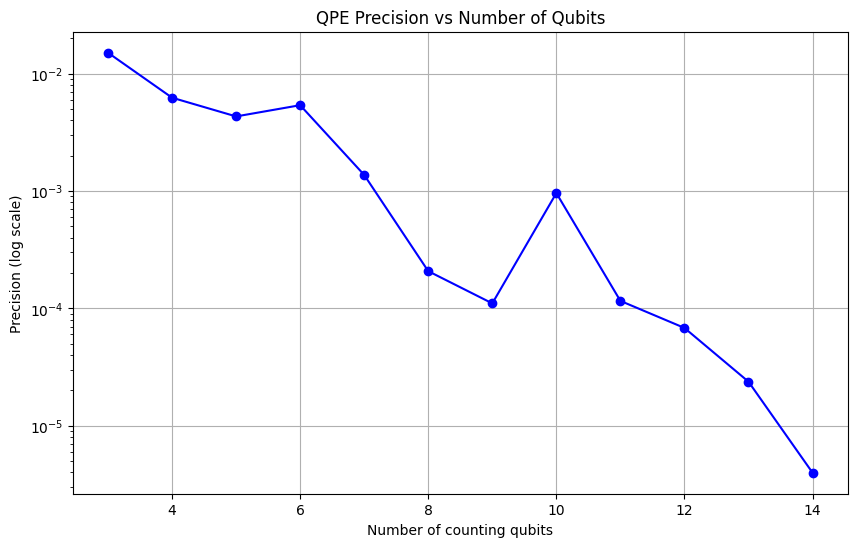

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot([r['n_qubits'] for r in results],
         [r['precision'] for r in results], 'bo-')
plt.yscale('log')
plt.xlabel('Number of counting qubits')
plt.ylabel('Precision (log scale)')
plt.title('QPE Precision vs Number of Qubits')
plt.grid(True)
plt.savefig('qpe_precision_transpiled.png')
# plt.close()



In [ ]:

# Print final results table
print("\nFinal Results Summary:")
print("----------------------")
print("Qubits | Measured θ | Precision")
print("----------------------")
for r in results:
    print(f"{r['n_qubits']:6d} | {r['measured_theta']:.6f} | {r['precision']:.6f}")


Final Results Summary:
----------------------
Qubits | Measured θ | Precision
----------------------
     3 | 0.615112 | 0.015112
     4 | 0.593750 | 0.006250
     5 | 0.595673 | 0.004327
     6 | 0.594604 | 0.005396
     7 | 0.601372 | 0.001372
     8 | 0.599792 | 0.000208
     9 | 0.599890 | 0.000110
    10 | 0.599039 | 0.000961
    11 | 0.600116 | 0.000116
    12 | 0.600068 | 0.000068
    13 | 0.599976 | 0.000024
    14 | 0.599996 | 0.000004


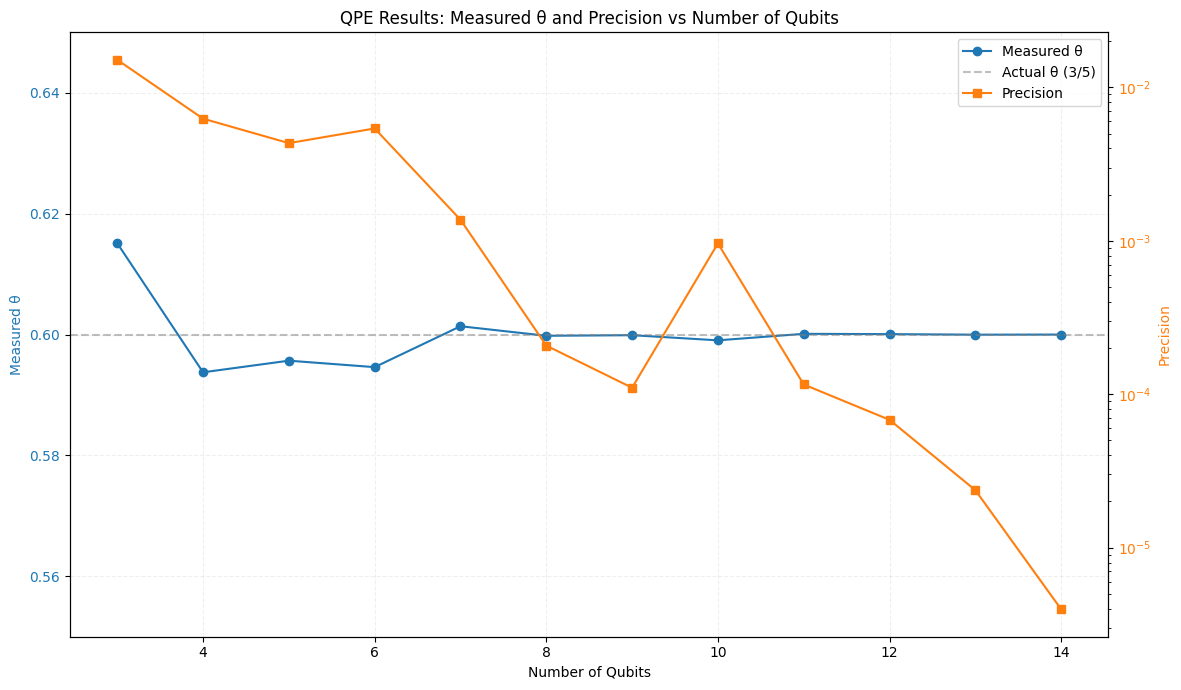

In [ ]:
rq
# Extract data from results
n_qubits = [r['n_qubits'] for r in results]
measured_thetas = [r['measured_theta'] for r in results]
precisions = [r['precision'] for r in results]

# Create figure and axis with two different y-scales
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot measured theta values on the primary y-axis
color1 = '#1f77b4'  # Blue
ax1.plot(n_qubits, measured_thetas, 'o-', color=color1, label='Measured θ')
ax1.set_xlabel('Number of Qubits')
ax1.set_ylabel('Measured θ', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Add horizontal line for actual theta value
ax1.axhline(y=3/5, color='gray', linestyle='--', alpha=0.5, label='Actual θ (3/5)')

# Create second y-axis for precision
ax2 = ax1.twinx()
color2 = '#ff7f0e'  # Orange
ax2.plot(n_qubits, precisions, 's-', color=color2, label='Precision')
ax2.set_ylabel('Precision', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_yscale('log')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Set title
plt.title('QPE Results: Measured θ and Precision vs Number of Qubits')

# Adjust layout to prevent label clipping
plt.tight_layout()

# Show grid
ax1.grid(True, which='both', linestyle='--', alpha=0.2)

# Set y-axis limits for measured theta to focus on relevant range
ax1.set_ylim(0.55, 0.65)

# Save the plot
plt.savefig('qpe_combined_results.png', dpi=300, bbox_inches='tight')